# 1. Imports

In [1]:
# Import libraries to verify installation
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


2024-05-24 17:27:06.115416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 17:27:07.080728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.4/lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-24 17:27:07.080887: W tensorflow/compiler/xla/stream_exec

In [3]:
# Check whether Tensorflow has enabled GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
TensorFlow version: 2.11.0


In [4]:
# Import the dataset
train_directory = './train'
test_directory = './test'
validation_directory = './valid'

train_img = [os.path.join(train_directory, f) for f in os.listdir(train_directory)]
test_img = [os.path.join(test_directory, f) for f in os.listdir(test_directory)]
valid_img = [os.path.join(validation_directory, f) for f in os.listdir(validation_directory)]

In [5]:
df_train = pd.read_csv("./birds.csv")
df_train.head()

,class id,filepaths,labels,data set,scientific name
0,0.0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI


# 2. Data Visualisation

We see that we have variying numbers of samples in the training set. In the test and validation sets, we have 5 samples each.

In [6]:
batch_size = 32

In [7]:
# Create an instance of ImageDataGenerator with desired augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Flow images from directory using the defined data generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 84635 images belonging to 525 classes.


In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 2625 images belonging to 525 classes.


In [9]:
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(validation_directory,
                                                target_size=(224,224),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 2625 images belonging to 525 classes.


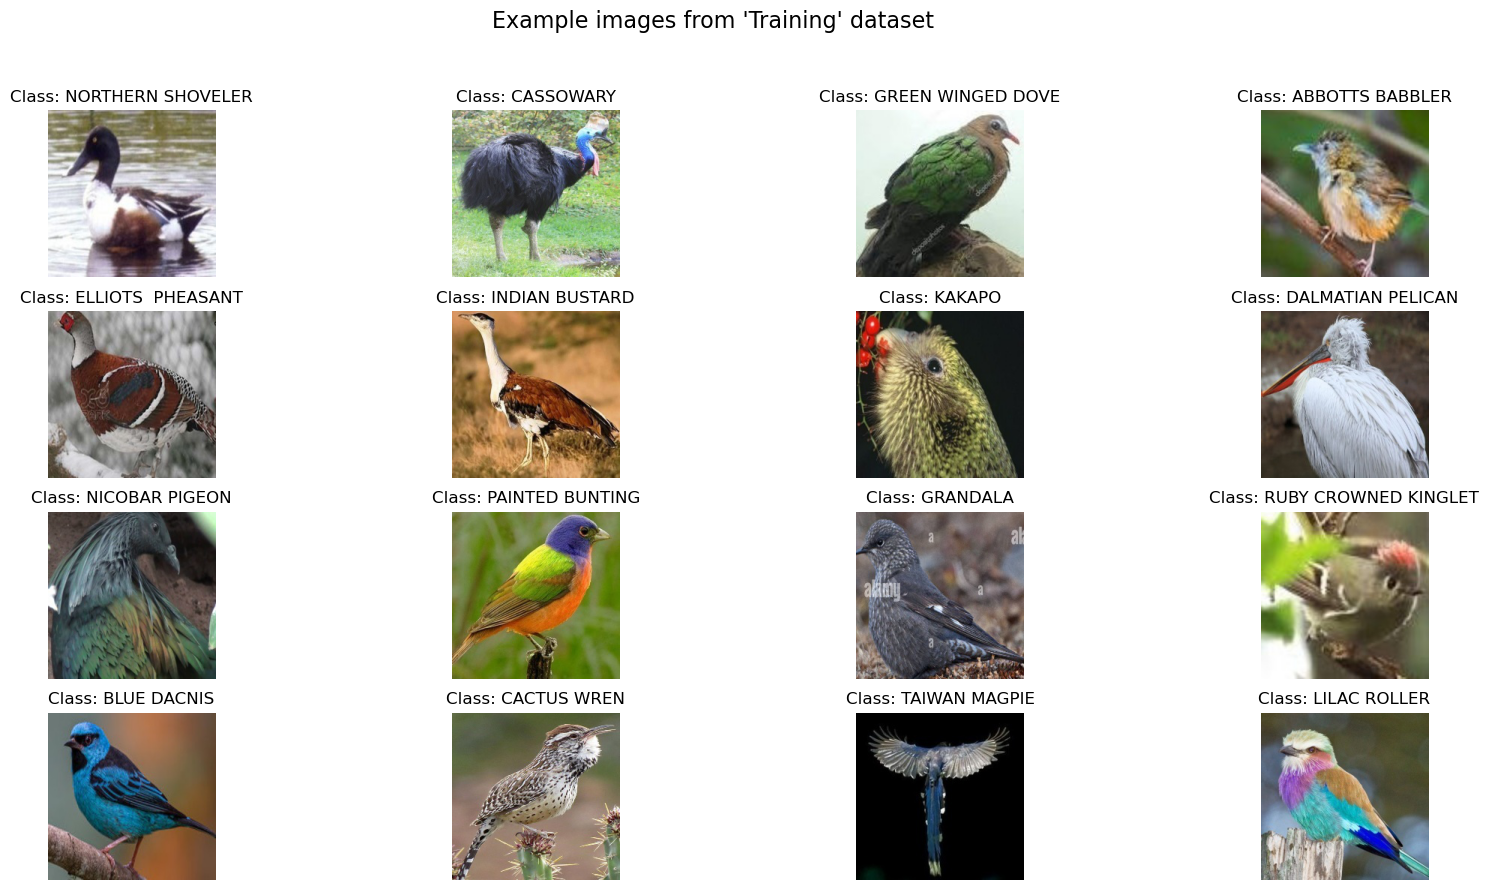

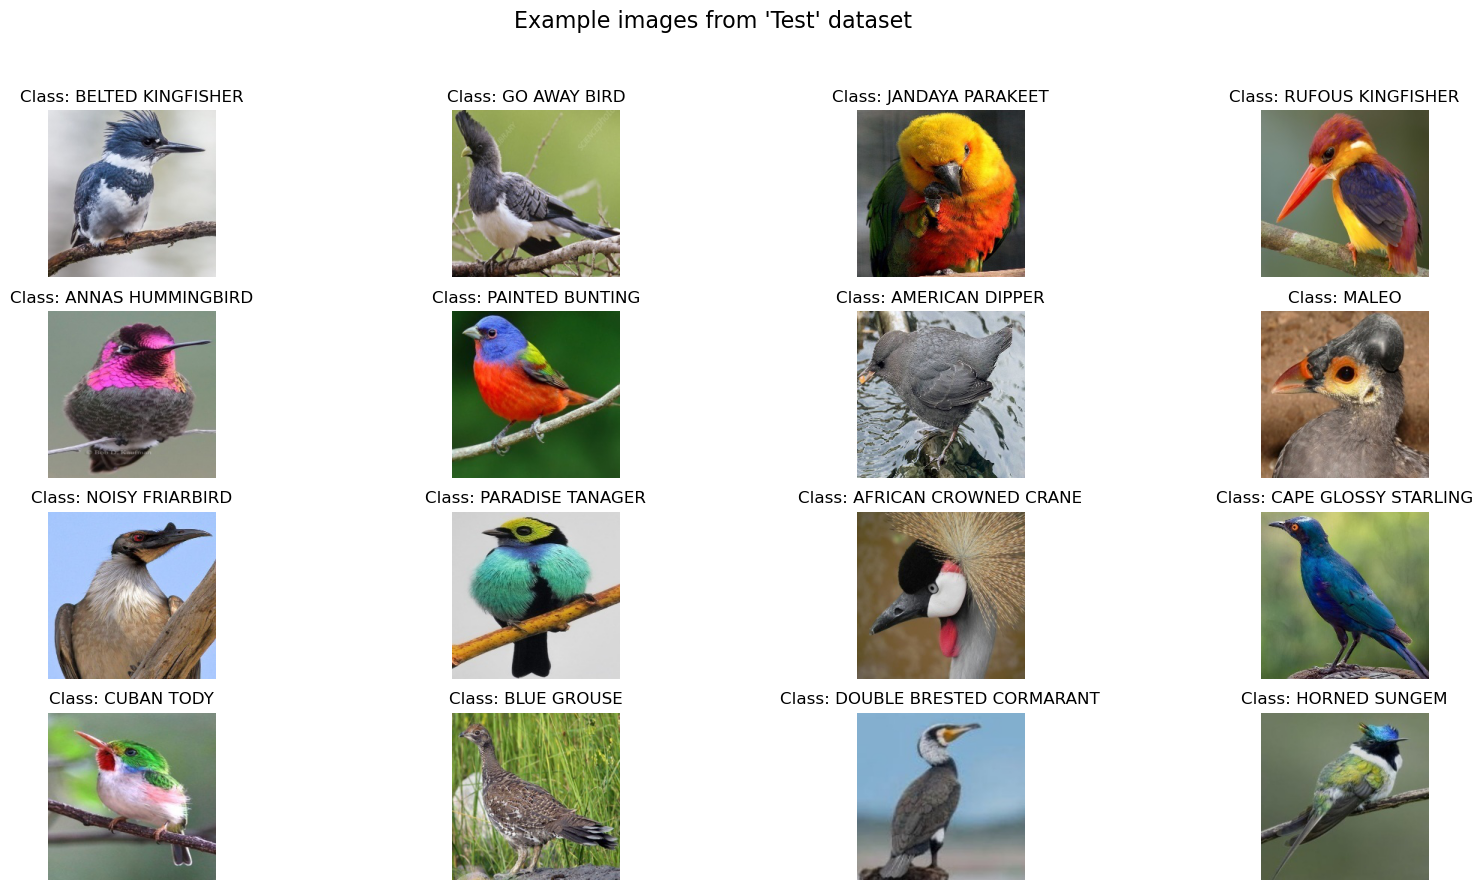

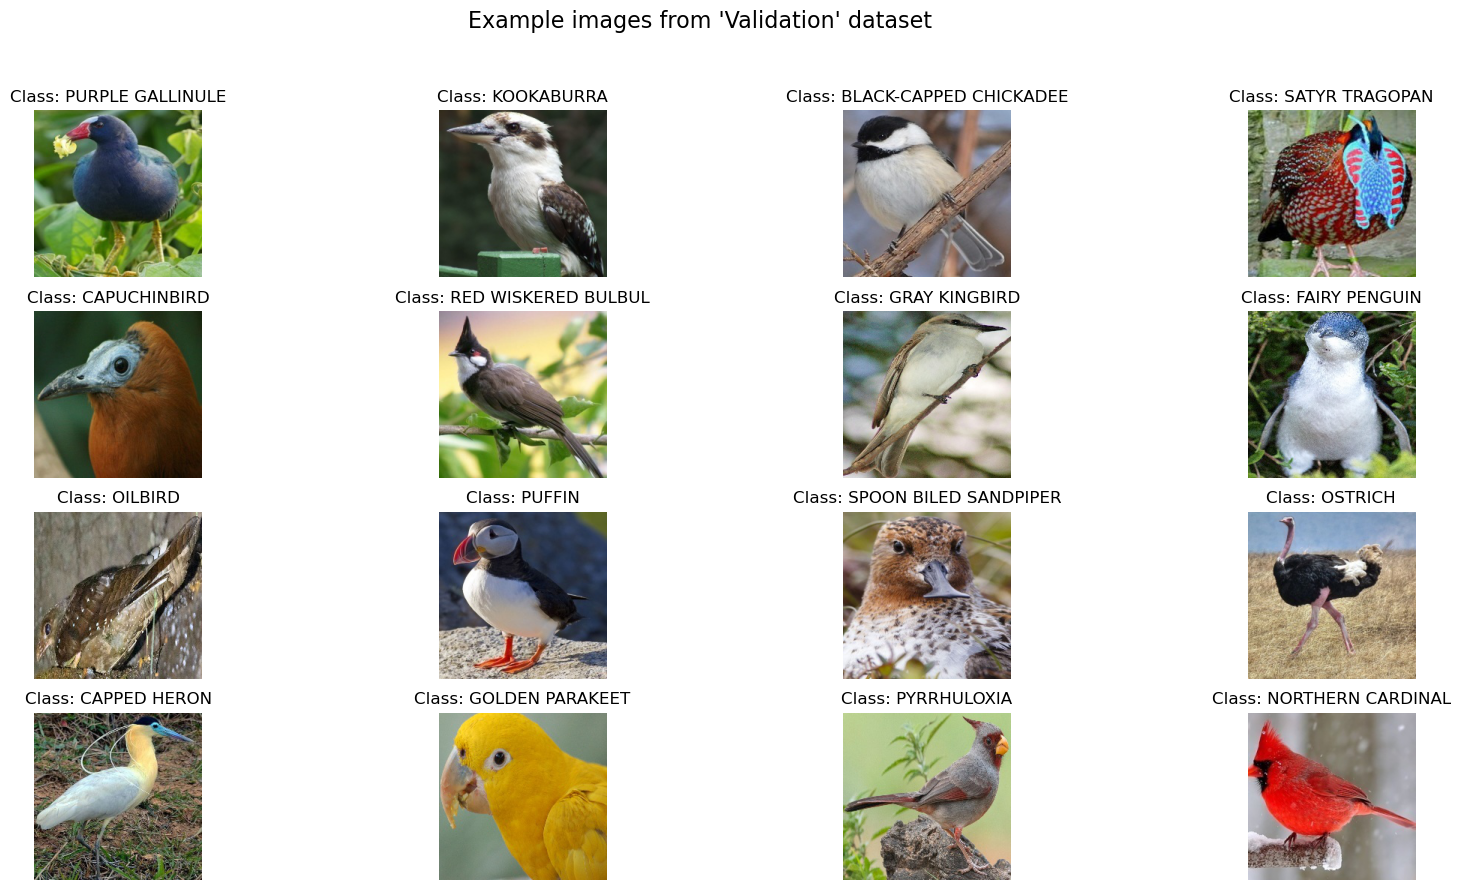

In [11]:
def visualize_data(data_directory, num_images, rows, class_names=None, dataset_name=None):
    plt.figure(figsize=(20, 10))
    if dataset_name:
        plt.suptitle(f"Example images from '{dataset_name}' dataset", fontsize=16)
    classes = os.listdir(data_directory)
    for i in range(num_images):
        # Randomly select a class (bird species)
        class_name = random.choice(classes)
        class_dir = os.path.join(data_directory, class_name)
        # Get a list of images in the class directory
        images = os.listdir(class_dir)
        # Randomly select an image from the class
        image_name = random.choice(images)
        image_path = os.path.join(class_dir, image_name)
        # Load and display the image
        image = Image.open(image_path)
        plt.subplot(rows, num_images // rows, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if class_names is not None:
            plt.title(f"Class: {class_names[class_name]}")
        else:
            plt.title(f"Class: {class_name}")


# Define class names (if available)
class_names = {
    'class1': 'Species 1',
    'class2': 'Species 2',
    # Add more class mappings as needed
}

# Visualize the training data
visualize_data(train_directory, num_images=16, rows=4, dataset_name='Training')

# Visualize the test data
visualize_data(test_directory, num_images=16, rows=4, dataset_name='Test')

# Visualize the validation data
visualize_data(validation_directory, num_images=16, rows=4, dataset_name='Validation')



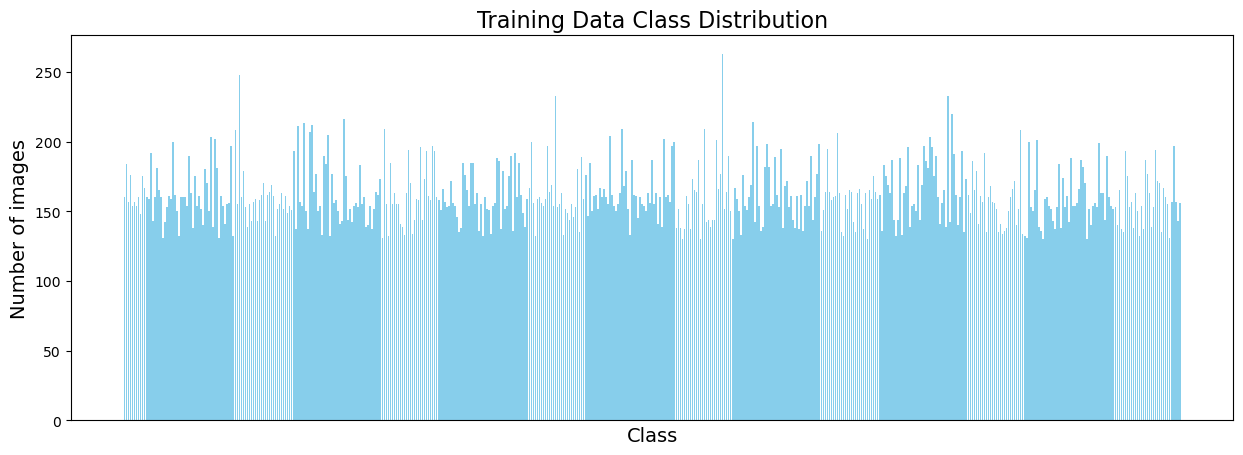

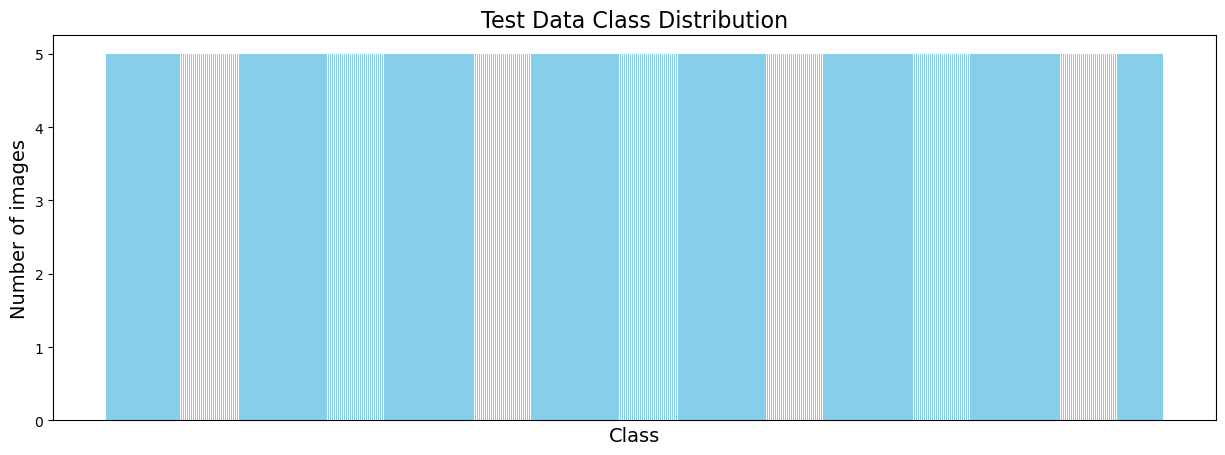

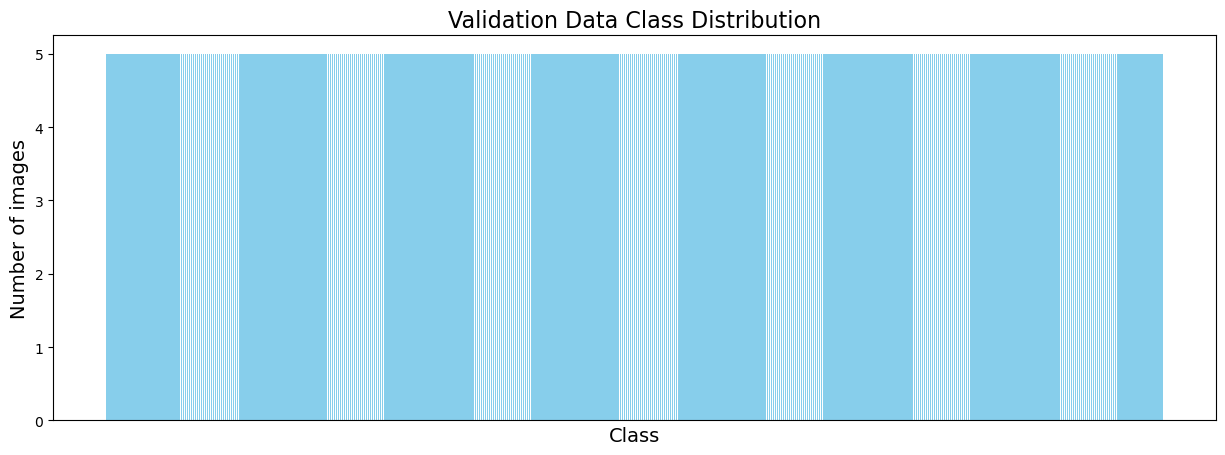

In [12]:
def plot_class_distribution(data_directory, title):
    # Filter out non-directory files (like .DS_Store)
    classes = [c for c in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, c))]
    num_images = [len(os.listdir(os.path.join(data_directory, c))) for c in classes]
    plt.figure(figsize=(15, 5))
    plt.bar(classes, num_images, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of images', fontsize=14)
    plt.xticks([])
    plt.show()
# Plot the class distribution for the training data
plot_class_distribution(train_directory, title='Training Data Class Distribution')

# Plot the class distribution for the test data
plot_class_distribution(test_directory, title='Test Data Class Distribution')

# Plot the class distribution for the validation data
plot_class_distribution(validation_directory, title='Validation Data Class Distribution')
